# setup

In [1]:
# Import packages
import re
import numpy as np
import pandas as pd
import csv
import json
import os
import random
import time
import tqdm
from pprint import pprint
from collections import defaultdict
from datasets import list_datasets, load_dataset
from tqdm import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
# !pip install pyLDAvis
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
path = '/Users/alexwey/Desktop/ipynb/'

In [4]:
# Import all json files
document_path = f'{path}documents/'
data = defaultdict(list)

for filename in os.listdir(document_path):
  d = json.JSONDecoder()
  with open(document_path + filename, 'r') as file:
    for record in file:
      record_data = d.decode(record)
      news_source = record_data['domain'].split('.')[0]
      if news_source != 'reddit':
        if news_source == 'huffingtonpost':
          news_source = 'huffpost'
        human_text = record_data['text']
        grover_text = record_data['gens_article'][0]
        data[news_source].append((human_text, grover_text))

total = 0
for key, value in data.items():
  print(key, len(value))
  total += len(value)

print('total', total)

breitbart 34
huffpost 36
foxnews 69
washingtonpost 67
total 206


In [ ]:
# ONLY CALL IF TRAINING MODEL ON CNN DAILY MAIL DATASET
datasets = list_datasets()

cnndailymail_dataset = list_datasets(with_details=True)[datasets.index('cnn_dailymail')]
pprint(cnndailymail_dataset.__dict__)  # It's a simple python data class

dataset = load_dataset('cnn_dailymail', '3.0.0', download_mode='reuse_cache_if_exists')

# preprocessing documents

In [5]:
# Remove emails, new lines, and single quotes
def preremoval(text):
  text = re.sub('\S*@\S*\s?', '', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub("\'", "", text)
  return text

# Tokenize
def tokenize(text):
  return(gensim.utils.simple_preprocess(str(text), deacc=True)) # deacc=True removes punctuations

# Remove stopwords
def remove_stopwords(texts):
  ret = []
  for i in tqdm (range (len(texts)), desc="Removing stopwords..."):
    ret.append((texts[i][0], texts[i][1], [word for word in simple_preprocess(str(texts[i][2])) if word not in stop_words]))
  return ret

# Make bigrams
def make_bigrams(nostops, tups):
  texts = [elem[2] for elem in tups]
  bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold, fewer phrases
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  ret = []
  for i in tqdm (range (len(nostops)), desc="Making bigrams..."):
    ret.append((nostops[i][0], nostops[i][1], bigram_mod[nostops[i][2]]))
  return ret

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

# Lemmatize
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  lemmatized_out = []
  for i in tqdm (range (len(texts)), desc="Lemmatizing..."):
    doc = nlp(" ".join(texts[i][2]))
    lemmatized_out.append((texts[i][0], texts[i][1], [token.lemma_ for token in doc if token.pos_ in allowed_postags]))

  return lemmatized_out

# Preprocess set of texts
def preprocess(texts):
  nostops = remove_stopwords(texts)
  bigrams = make_bigrams(nostops, texts)
  lemmatized_out = lemmatization(bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
  return lemmatized_out

In [6]:
# Collect dataset
all_texts = []
tokenized = []
for source, docs in data.items():
  for tup in docs:
    human_words = tokenize(preremoval(tup[0]))
    grover_words = tokenize(preremoval(tup[1]))
    tokenized.append((source, 'h', human_words))
    tokenized.append((source, 'g', grover_words))
    all_texts.append((source, tup[0], tup[1]))

In [ ]:
# ONLY CALL IF TRAINING MODEL ON CNN DAILY MAIL DATASET
cnn_train = dataset['train'][:]['article']
cnn_validation = dataset['validation'][:]['article']

train_len = len(cnn_train)
validation_len = len(cnn_validation)

for i in tqdm (range (train_len), desc="Processing training data..."):
    cnn_words = tokenize(preremoval(cnn_train[i]))
    tokenized.append(('CNN', 'n/a', cnn_words))

for i in tqdm (range (validation_len), desc="Processing validation data..."):
    cnn_words = tokenize(preremoval(cnn_validation[i]))
    tokenized.append(('CNN', 'n/a', cnn_words))

In [7]:
# Preprocess data
preprocessed_data = preprocess(tokenized)

Lemmatizing...: 100%|██████████| 412/412 [00:17<00:00, 24.22it/s]


In [8]:
# Aggregate data accordingly
all_data = []
news_human_data = []
news_grover_data = []

for doc in lemmatized_out:
  all_data.append(doc[2])

  if doc[0] != 'reddit':
    if doc[1] == 'h':
      news_human_data.append(doc[2])
    elif doc[1] == 'g':
      news_grover_data.append(doc[2])

print(all_data[:2])
print(all_texts[:2])

[['little', 'midnight', 'cross', 'bridge', 'laredo', 'texas', 'sister', 'city', 'nuevo', 'laredo', 'mexico', 'car', 'search', 'clear', 'mexican', 'custom', 'check', 'point', 'military', 'stage', 'drive', 'destination', 'source', 'mine', 'local', 'reporter', 'call', 'hour', 'early', 'tell', 'meet', 'specific', 'restaurant', 'photograph', 'information', 'look', 'pertain', 'specific', 'series', 'brutal', 'murder', 'take', 'place', 'laredo', 'corridor', 'be', 'unusual', 'investigative', 'journalist', 'mexico', 'work', 'intense', 'circumstance', 'give', 'often', 'come', 'information', 'relate', 'drug', 'cartel', 'report', 'death', 'sentence', 'give', 'information', 'air', 'publish', 'way', 'connect', 'arrive', 'early', 'restaurant', 'weather', 'pleasant', 'decide', 'take', 'seat', 'patio', 'glass', 'tea', 'sit', 'minute', 'source', 'arrive', 'sit', 'order', 'drink', 'hand', 'large', 'white', 'envelope', 'tell', 'ask', 'editor', 'day', 'careful', 'thanked', 'pay', 'talk', 'minute', 'ask', 'g

In [9]:
# Calculate average lengths of prompts/generations for normalization
news_prompt_avg_len, news_generation_avg_len, news_c = 0, 0, 0
news_prompt_min, news_prompt_max = float('inf'), 0
news_generation_min, news_generation_max = float('inf'), 0
news_prompt_list_len, news_generation_list_len = [], []

for source, texts in data.items():
  if source != 'reddit':
    for pairs in texts:
      news_c += 1
      prompt_len = len(pairs[0].split())
      generation_len = len(pairs[1].split())
      news_prompt_avg_len += prompt_len
      news_generation_avg_len += generation_len
      news_prompt_list_len.append(prompt_len)
      news_generation_list_len.append(generation_len)
      if prompt_len < news_prompt_min:
        news_prompt_min = prompt_len
      if generation_len < news_generation_min:
        news_generation_min = generation_len
      if prompt_len > news_prompt_max:
        news_prompt_max = prompt_len
      if generation_len > news_generation_max:
        news_generation_max = generation_len

# Calculate average length
news_prompt_avg_len /= news_c
news_generation_avg_len /= news_c

# Calculate standard error
news_prompt_list_np = np.array(news_prompt_list_len)
news_generation_list_np = np.array(news_generation_list_len)
news_prompt_std_err = np.std(news_prompt_list_np, ddof=1) / np.sqrt(np.size(news_prompt_list_np))
news_generation_std_err = np.std(news_generation_list_np, ddof=1) / np.sqrt(np.size(news_generation_list_np))

print("News Prompt Min: ", news_prompt_min)
print("News Prompt Max: ", news_prompt_max)
print("News Generation Min: ", news_generation_min)
print("News Generation Max: ", news_generation_max)
print("News Prompt Avg Length: ", news_prompt_avg_len)
print("News Generation Avg Length: ", news_generation_avg_len)
print("News Prompt Std Err: ", news_prompt_std_err)
print("News Generation Std Err: ", news_generation_std_err)

News Prompt Min:  39
News Prompt Max:  4188
News Generation Min:  164
News Generation Max:  811
News Prompt Avg Length:  516.9805825242719
News Generation Avg Length:  437.1601941747573
News Prompt Std Err:  32.569075547746394
News Generation Std Err:  11.52182057501453


# run model

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(all_data)

# Create Corpus
texts = all_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Initialize num_topics
num_topics = 50

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

# save/load LDA model

In [ ]:
# Save LDA model and dictionary
lda_model.save(f'{path}pretrained_models/news/lda_model_news.lda')
id2word.save(f'{path}pretrained_models/news/id2word_news.lda.id2word')

In [11]:
# Load id2word
pretrained_id2word = corpora.Dictionary.load(f'{path}pretrained_models/news/lda_model_news.lda.id2word')

# Load LDA Model and dictionary
pretrained_lda_model = gensim.models.ldamodel.LdaModel.load(f'{path}pretrained_models/news/lda_model_news.lda')

# coherence values

In [12]:
# Obtain coherence model
cm = CoherenceModel(model=pretrained_lda_model, texts=all_data, corpus=corpus, dictionary=pretrained_id2word, coherence='u_mass')

# Obtain segmented topics
segmented_topics = cm.segment_topics()

# Calculate topic specific coherence values
coherence_values = cm.get_coherence_per_topic(segmented_topics)

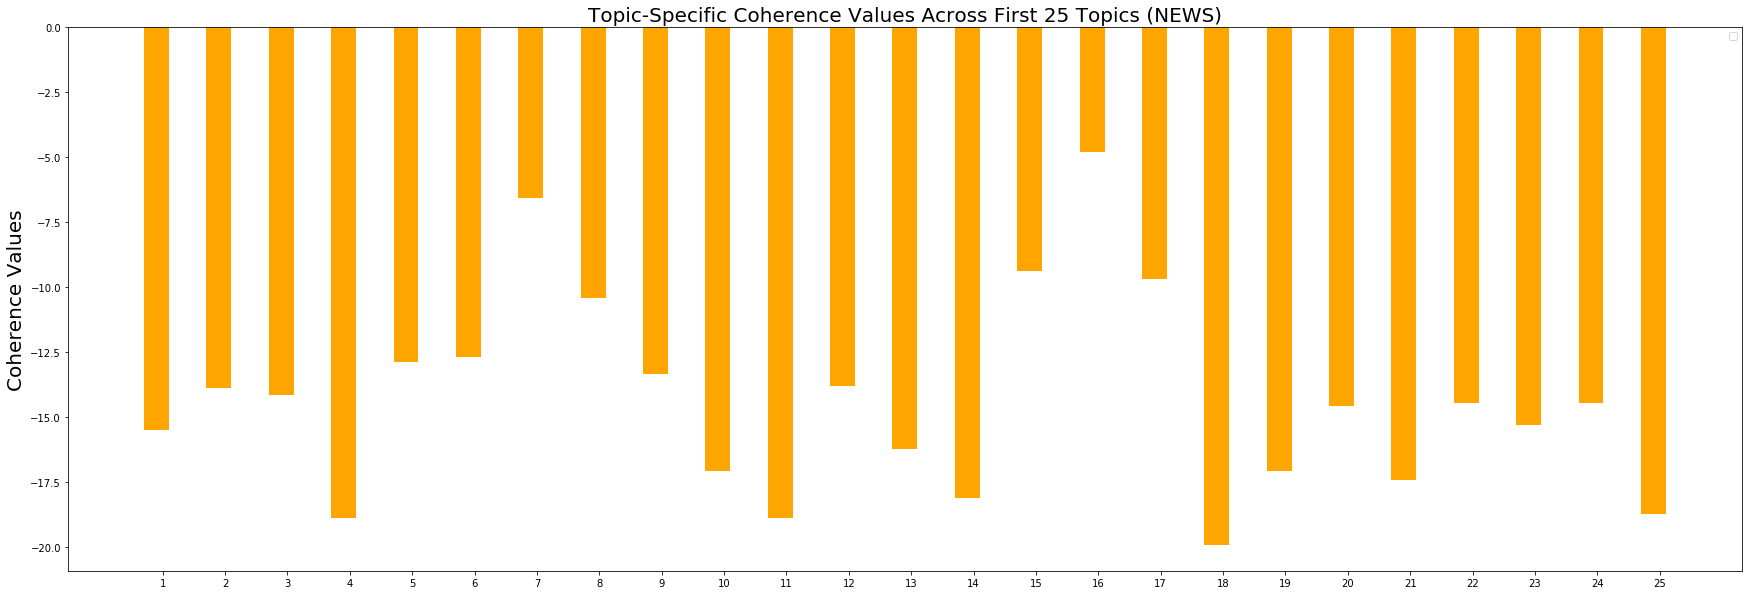

In [13]:
# Configure specifications for bar plot
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, coherence_values[:25], color='orange', width=0.4)

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Coherence Values', fontsize=20)
ax.set_title('Topic-Specific Coherence Values Across First 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

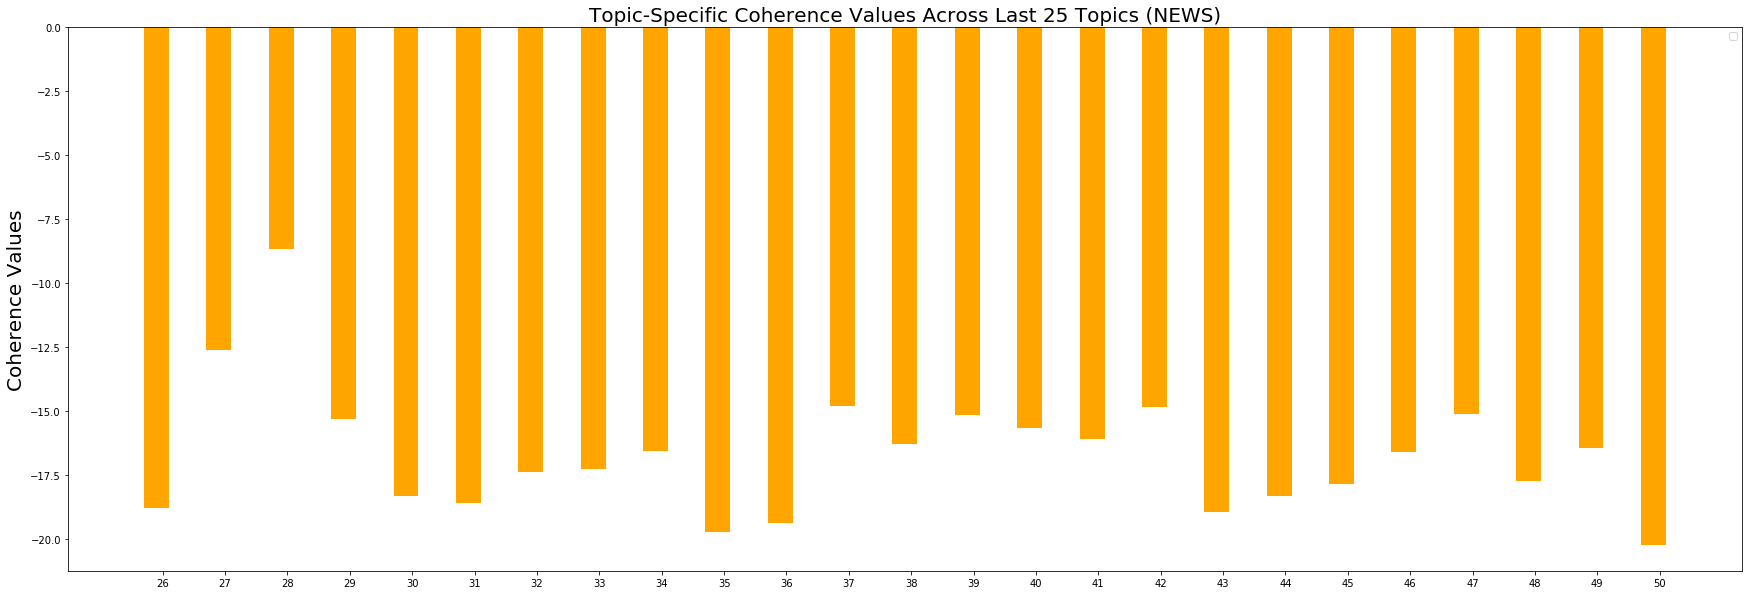

In [14]:
# Configure specifications for bar plot
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, coherence_values[25:], color='orange', width=0.4)

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Coherence Values', fontsize=20)
ax.set_title('Topic-Specific Coherence Values Across Last 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# topic distribution preprocessing



In [36]:
# Convert documents to BoW format
def convert_to_bow(words_set):
  bows = []
  for words in words_set:
    bow = pretrained_id2word.doc2bow(words)
    bows.append(bow)
  return bows

# Obtain topic distribution for all documents
def get_topic_dist(documents, pwt):
  outputs = []
  for document in documents:
    if pwt:
      output = pretrained_lda_model.get_document_topics(document, per_word_topics=True)
      outputs.append(output)
    else:
      output = pretrained_lda_model.get_document_topics(document)
      outputs.append(output)
  return outputs

In [16]:
# Convert data to BoW
news_human_bow = convert_to_bow(news_human_data)
news_grover_bow = convert_to_bow(news_grover_data)

# Obtain distribution (pwt = False)
news_human_dist = get_topic_dist(news_human_bow, False)
news_grover_dist = get_topic_dist(news_grover_bow, False)

# Make a copy
news_human_dist_copy = news_human_dist
news_grover_dist_copy = news_grover_dist

# average word counts across topics

In [17]:
# Get the number of words contributed by topics
def calc_words(dist, dist_pwt):
  for i in range(len(dist)):
    word_count = get_word_count(dist_pwt[i][1])
    for j in range(len(dist[i])):
      topic_id = dist[i][j][0]
      contribution = dist[i][j][1]
      dist[i][j] = (topic_id, contribution * word_count)

def get_word_count(output):
    count = 0
    for tup in output:
        if len(tup[1]) > 0:
            count += 1
    return count

# Normalize word contributions (try this with z-score approach, subtract mean and divide by std dev)
def normalize_wc(dist):
    x_mean, doc_count = 0, 0
    tups = [tup for doc_dist in dist for tup in doc_dist]
    wc_list = []
    for tup in tups:
        wc = tup[1]
        x_mean += wc
        doc_count += 1
        wc_list.append(wc)

    x_mean /= doc_count
    x_std = np.std(np.array(wc_list))
    
    for i in range(len(dist)):
        for j in range(len(dist[i])):
          topic_id = dist[i][j][0]
          wc_not_norm = dist[i][j][1]
          wc_norm = (wc_not_norm - x_mean) / x_std
          dist[i][j] = (topic_id, wc_norm)
            
#   x_min, x_max = float('inf'), 0
#   tups = [tup for doc_dist in dist for tup in doc_dist]
#   for tup in tups:
#     wc = tup[1]
#     if wc < x_min:
#       x_min = wc
#     if wc > x_max:
#       x_max = wc

#   for i in range(len(dist)):
#     for j in range(len(dist[i])):
#       topic_id = dist[i][j][0]
#       wc_not_norm = dist[i][j][1]
#       wc_norm = (wc_not_norm - x_min) / (x_max - x_min)
#       dist[i][j] = (topic_id, wc_norm)

# Get averages after normalizing data
def average(dist):
  tups = [tup for doc_dist in dist for tup in doc_dist]
  sums = [0] * num_topics
  counts = [0] * num_topics
  for tup in tups:
    idx = tup[0]
    sums[idx] += tup[1]
    counts[idx] += 1
  avg_data = [sum / count for sum, count in zip(sums, counts)] 
  return avg_data

In [18]:
# Obtain distribution (pwt = True)
news_human_dist_pwt = get_topic_dist(news_human_bow, True)
news_grover_dist_pwt = get_topic_dist(news_grover_bow, True)

# Calculate number of words per document
calc_words(news_human_dist, news_human_dist_pwt)
calc_words(news_grover_dist, news_grover_dist_pwt)

# Normalize word conributions
normalize_wc(news_human_dist)
normalize_wc(news_grover_dist)

# Calculate average number of words
news_human_avg = average(news_human_dist)
news_grover_avg = average(news_grover_dist)

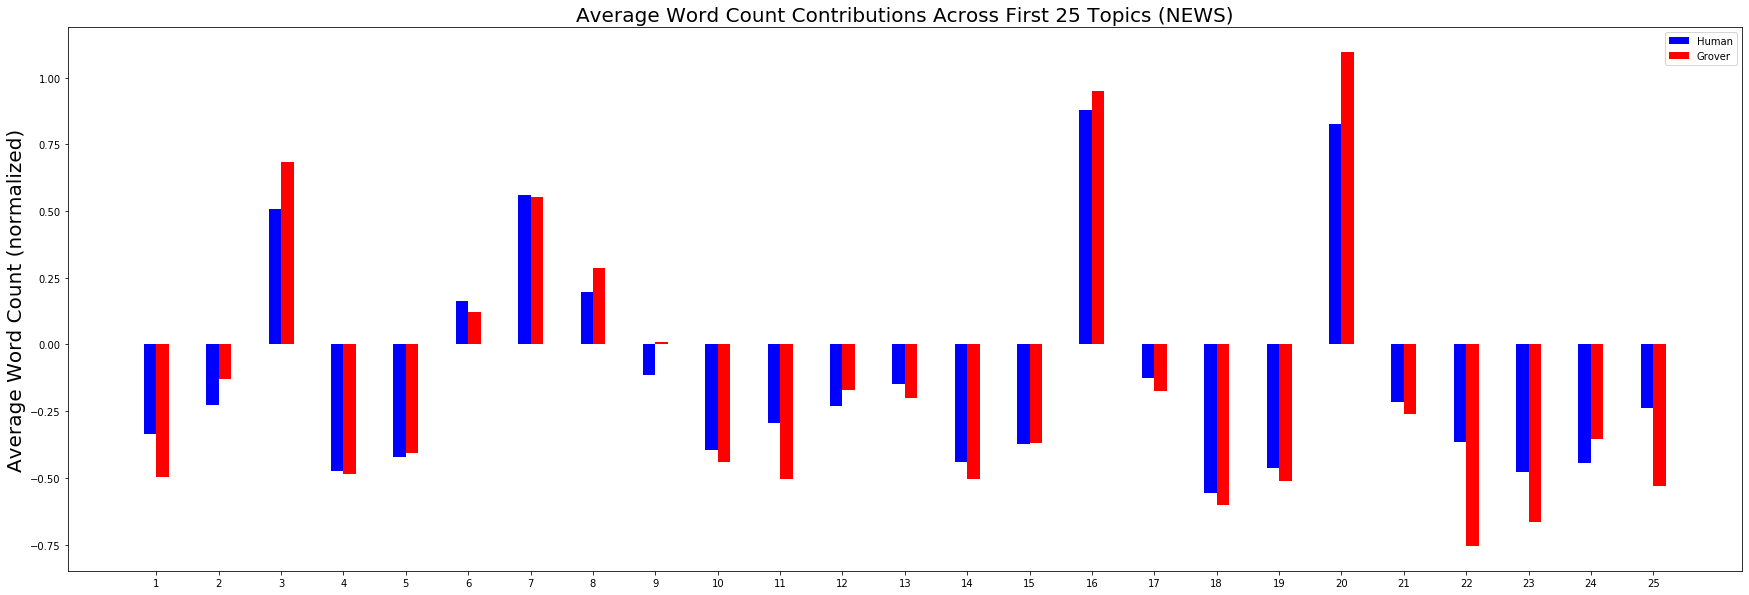

In [19]:
# Configure specifications for bar plot (NEWS)
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, news_human_avg[:25], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, news_grover_avg[:25], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average Word Count (normalized)', fontsize=20)
ax.set_title('Average Word Count Contributions Across First 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

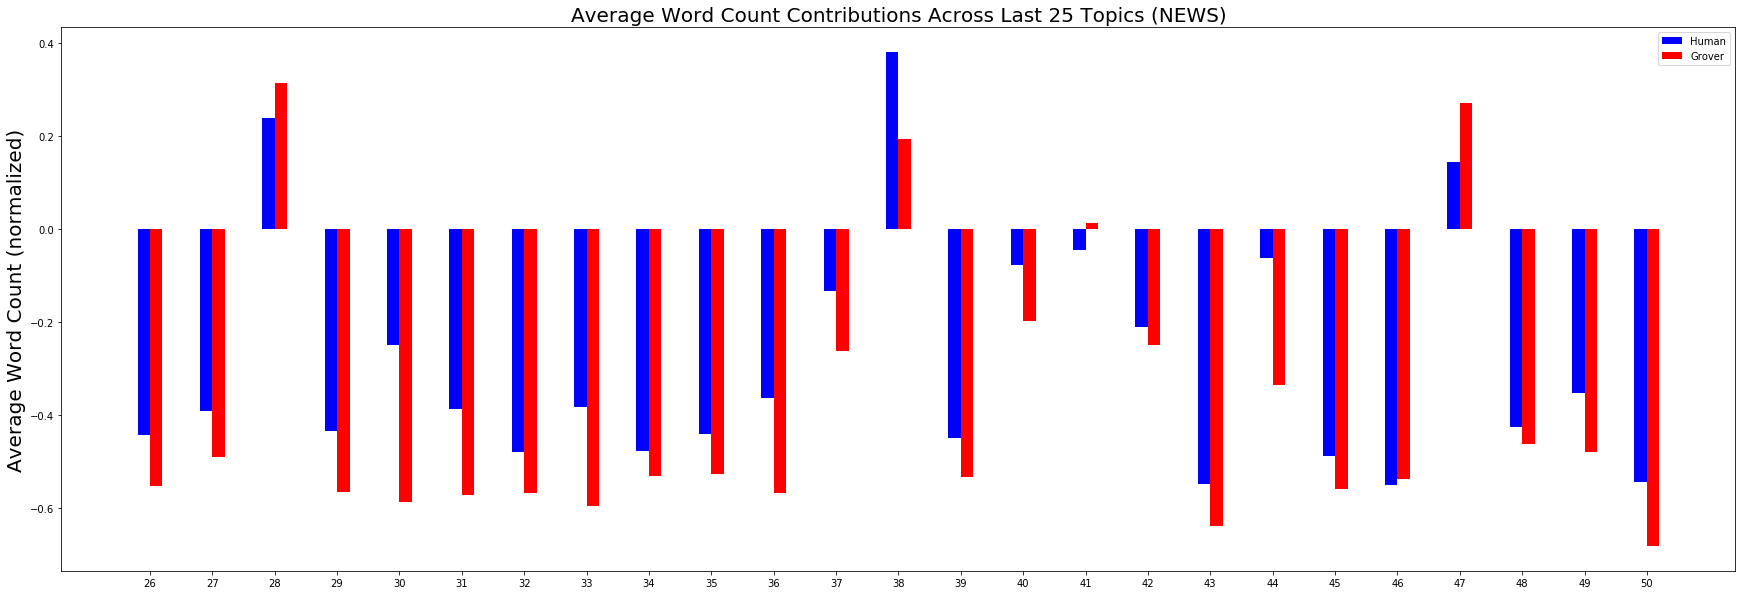

In [20]:
# Configure specifications for bar plot (NEWS)
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, news_human_avg[25:], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, news_grover_avg[25:], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average Word Count (normalized)', fontsize=20)
ax.set_title('Average Word Count Contributions Across Last 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# difference in average word counts across topics

In [21]:
# Calculates difference in distributions
def calc_difs(human, grover):
  res = []
  for i in range(len(human)):
    human_dist_dic = dict(human[i])
    grover_dist_dic = dict(grover[i])

    for key in human_dist_dic.keys():
      if key not in grover_dist_dic.keys():
        grover_dist_dic[key] = 0
    for key in grover_dist_dic.keys():
      if key not in human_dist_dic.keys():
        human_dist_dic[key] = 0
    
    difs_dic = {}
    for key, val in human_dist_dic.items():
      difs_dic[key] = human_dist_dic[key] - grover_dist_dic[key]
    difs_tups = [(k, v) for k, v in difs_dic.items()]
    res.append(difs_tups)
      
  return res

In [22]:
# Calculate differences in topic contributions
news_difs = calc_difs(news_human_dist, news_grover_dist)

# Calculate average of differences
news_difs_avg = average(news_difs)

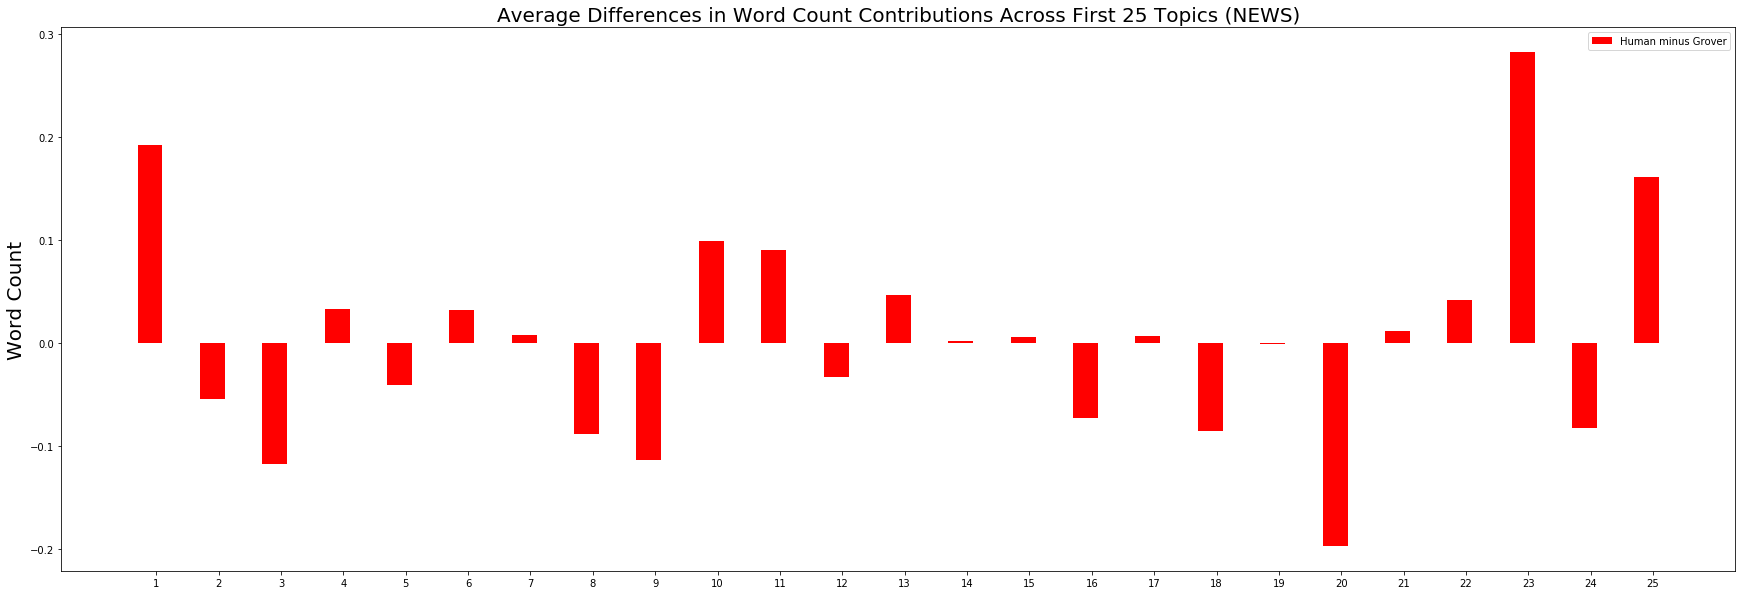

In [23]:
# Configure specifications for bar plot (NEWS)
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, news_difs_avg[:25], color='r', width=0.4, label='Human minus Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Word Count', fontsize=20) # average number of words per topic instead
ax.set_title('Average Differences in Word Count Contributions Across First 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

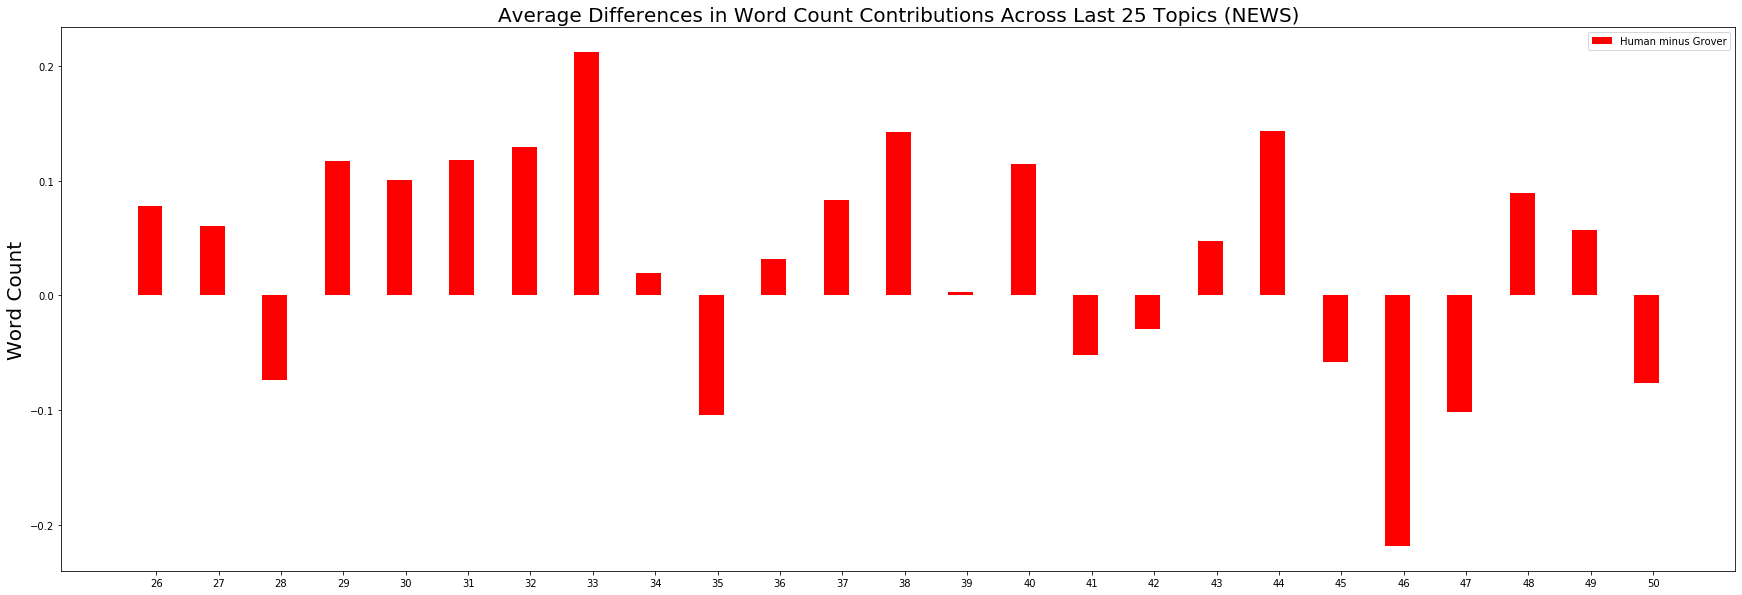

In [24]:
# Configure specifications for bar plot (NEWS)
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, news_difs_avg[25:], color='r', width=0.4, label='Human minus Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Word Count', fontsize=20) # average number of words per topic instead
ax.set_title('Average Differences in Word Count Contributions Across Last 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# documents higher than 50% more than uniform distribution

In [25]:
# Count number of documents 50% higher than uniform distribution
def count_high_threshold(dist):
  threshold = 1.5/num_topics
  count = [0] * num_topics
  for doc in dist:
    for tup in doc:
      if tup[1] > threshold:
        count[tup[0]] += 1
  return count

In [26]:
# Count number of documents higher than 50% threshold
news_human_higher = count_high_threshold(news_human_dist_copy)
news_grover_higher = count_high_threshold(news_grover_dist_copy)

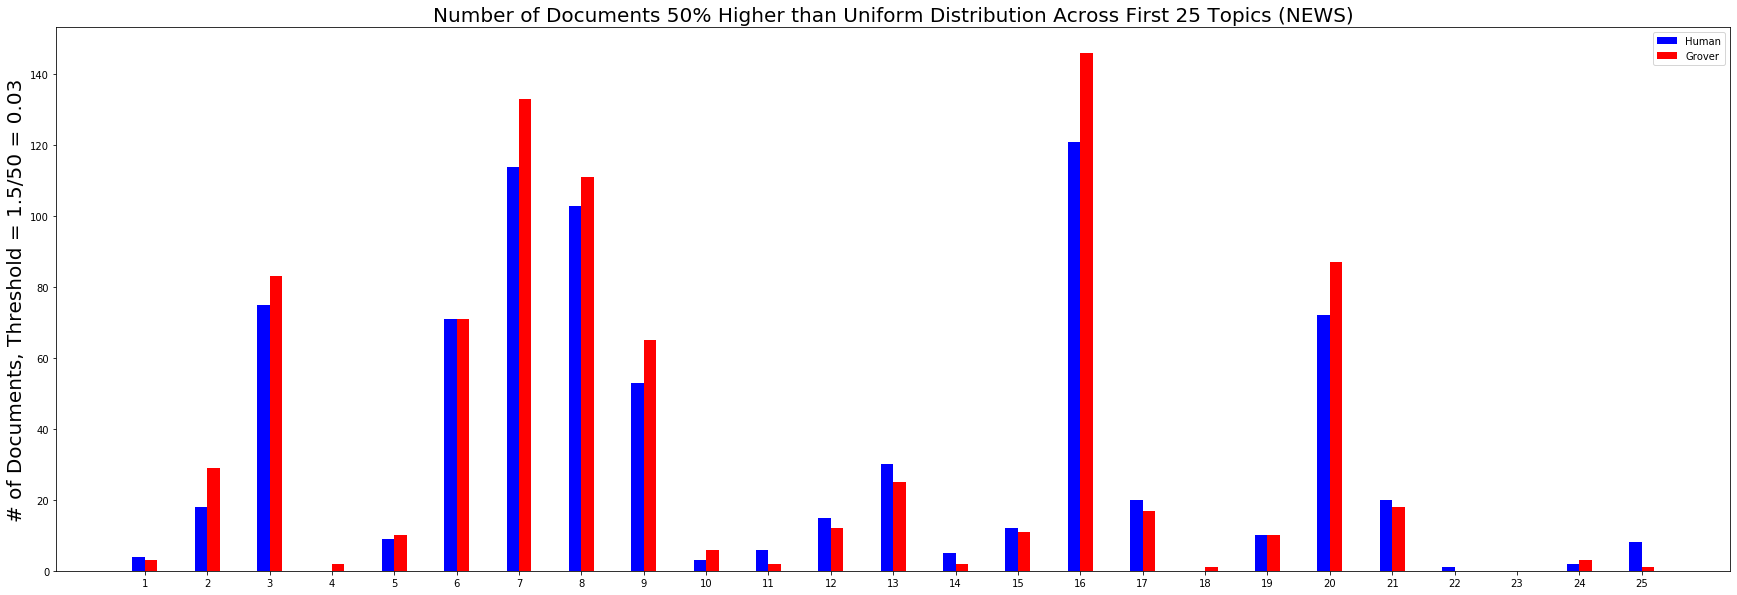

In [27]:
# Configure specifications for bar plot (NEWS)
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, news_human_higher[:25], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, news_grover_higher[:25], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('# of Documents, Threshold = 1.5/50 = 0.03', fontsize=20)
ax.set_title('Number of Documents 50% Higher than Uniform Distribution Across First 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

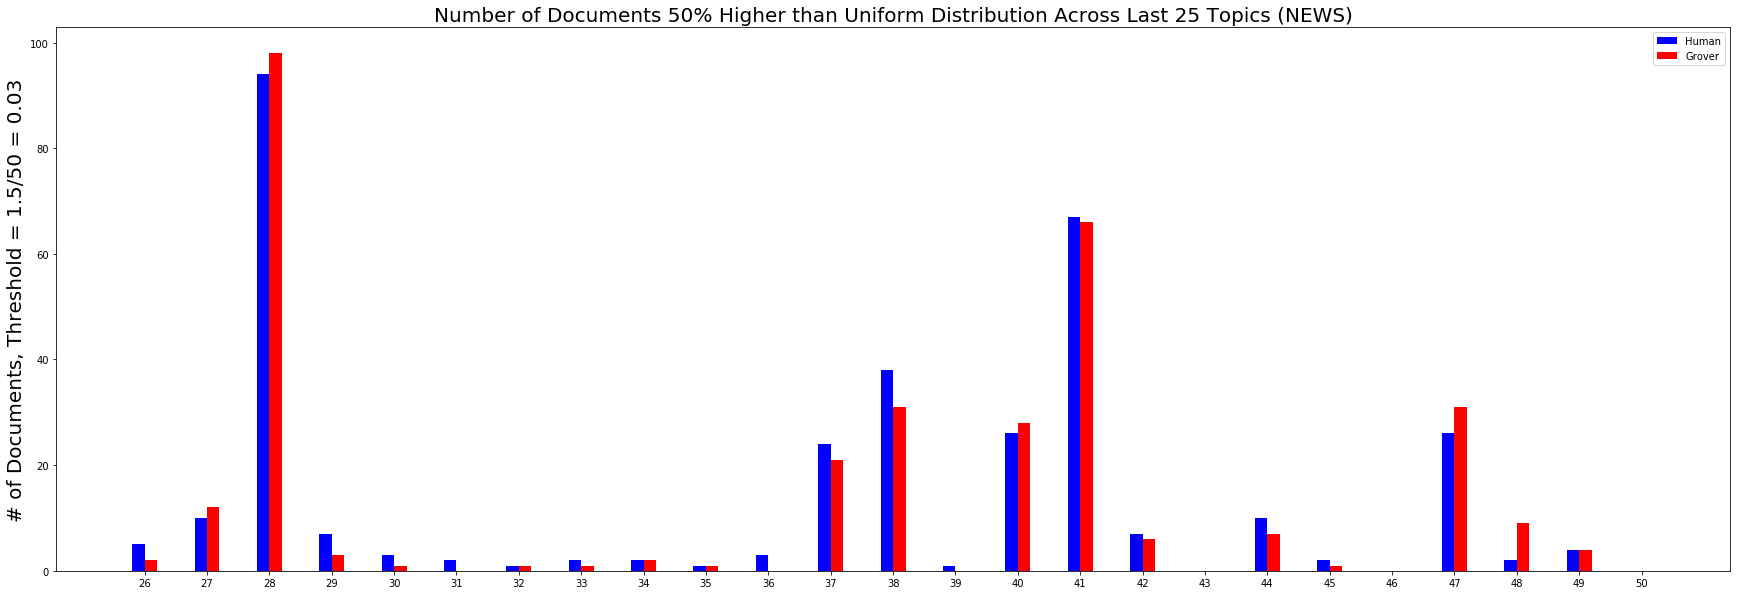

In [28]:
# Configure specifications for bar plot (NEWS)
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, news_human_higher[25:], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, news_grover_higher[25:], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('# of Documents, Threshold = 1.5/50 = 0.03', fontsize=20)
ax.set_title('Number of Documents 50% Higher than Uniform Distribution Across Last 25 Topics (NEWS)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# single-most/least representative documents

In [29]:
# Get texts for Reddit/News
news_texts = [text for text in all_texts if text[0] != 'reddit']

In [30]:
# Document that is single-most/least representative of differences in topic contributions
def most_representative(difs):
  human_most, human_idx = (-1, 0), -1
  grover_most, grover_idx = (-1, 0), -1
  for i, doc in enumerate(difs):
    for tup in doc:
      if tup[1] > human_most[1]:
        human_most = tup
        human_idx = i
      if tup[1] < grover_most[1]:
        grover_most = tup
        grover_idx = i
  
  return human_idx, grover_idx, human_most, grover_most

def least_representative(difs):
  human_least, human_idx = (-1, float('inf')), -1
  grover_least, grover_idx = (-1, float('-inf')), -1
  for i, doc in enumerate(difs):
    for tup in doc:
      if tup[1] < human_least[1] and tup[1] > 0:
        human_least = tup
        human_idx = i
      if tup[1] > grover_least[1] and tup[1] < 0:
        grover_least = tup
        grover_idx = i
    
  return human_idx, grover_idx, human_least, grover_least

def find_print_results(most, human_idx, grover_idx, human_res, grover_res, all, reddit, news):
  if all:
    human_rep = all_texts[human_idx]
    grover_rep = all_texts[grover_idx]
  if reddit:
    human_rep = reddit_texts[human_idx]
    grover_rep = reddit_texts[grover_idx]
  if news:
    human_rep = news_texts[human_idx]
    grover_rep = news_texts[grover_idx]

  if most:
    print('Most Representative Human Document:')
  else:
    print('Least Representative Human Document:')
  print(human_res, human_idx)
  print('SOURCE:', human_rep[0])
  print('HUMAN:', human_rep[1])
  print('GROVER:', human_rep[2])

  if most:
    print('Most Representative Grover Document:')
  else:
    print('Least Representative Grover Document:')
  print(grover_res, grover_idx)
  print('SOURCE:', grover_rep[0])
  print('HUMAN:', grover_rep[1])
  print('GROVER:', grover_rep[2])

In [31]:
news_hidx, news_gidx, human_res, grover_res = most_representative(news_difs)
find_print_results(True, news_hidx, news_gidx, human_res, grover_res, False, False, True)
print('\n')
news_hidx, news_gidx, human_res, grover_res = least_representative(news_difs)
find_print_results(False, news_hidx, news_gidx, human_res, grover_res, False, False, True)

Most Representative Human Document:
(15, 13.152253550214823) 151
SOURCE: washingtonpost
HUMAN: Johnsie Gooslin spent Jan. 16, 2015, tending his babies that's what he called his marijuana plants. More than 70 of them were growing in a hydroponic system of his own design. Sometimes, he'd stay in his barn for 16 hours straight, perfecting his technique. That night, he left around 8 o'clock to head home. The moon was waning, down to a sliver, which left the sky as dark as the ridges that lined it. As he pulled away, the lights from his late-model Kia swept across his childhood hollow and his parents' trailer, which stood just up the road from the barn. He turned onto West Virginia Route 65. Crossing Mingo County, he passed the Delbarton Mine, where he had worked on and off for 14 years before his back gave out. Though Johnsie was built like a linebacker, falling once from a coal truck and twice from end loaders had taken a toll. At 36, his disks were a mess, and sciatica sometimes shot pai

# topic words analysis

In [32]:
# Obtain most probable words under each topic
def get_topic_words():
  res = {}
  for i in range(num_topics): # change depending on # topics
    print(f'Topic {i + 1}')
    top_idxs = pretrained_lda_model.get_topic_terms(i, topn=40) # increase depending on if sets have limited number of unique words
    top_words = [pretrained_id2word[word_id[0]] for word_id in top_idxs]
    print(top_words)
    res[f'Topic {i + 1}'] = top_words
  return res
  
topic_words = get_topic_words()

Topic 1
['online', 'site', 'fly', 'airport', 'website', 'phone', 'pilot', 'air', 'datum', 'internet', 'service', 'board', 'people', 'video', 'access', 'user', 'page', 'information', 'youtube', 'mail', 'land', 'control', 'transport', 'privacy', 'delay', 'com', 'call', 'check', 'shopping', 'hour', 'company', 'use', 'search', 'safety', 'regularly', 'base', 'date', 'sky', 'account', 'firm']
Topic 2
['president', 'obama', 'security', 'house', 'white', 'state', 'email', 'washington', 'committee', 'program', 'secret', 'administration', 'congress', 'official', 'intelligence', 'federal', 'ambassador', 'american', 'government', 'department', 'senator', 'speaker', 'expose', 'national', 'address', 'adviser', 'ally', 'united_state', 'defense', 'cia', 'fbi', 'president_barack', 'aide', 'hammond', 'indication', 'executive', 'rep', 'representative', 'senate', 'sen']
Topic 3
['law', 'ban', 'rule', 'legal', 'appeal', 'allow', 'state', 'right', 'case', 'fine', 'decision', 'gay', 'lawsuit', 'act', 'oklaho

['attack', 'incident', 'kill', 'people', 'russian', 'carry', 'threat', 'wound', 'strike', 'force', 'violence', 'threaten', 'group', 'control', 'area', 'raid', 'dead', 'dangerous', 'fear', 'town', 'attempt', 'north', 'try', 'northern', 'nearby', 'deadly', 'happen', 'cross', 'fence', 'relative', 'least', 'crowd', 'gather', 'border', 'other', 'province', 'cause', 'reportedly', 'blow', 'dozen']
Topic 25
['water', 'island', 'sea', 'coast', 'tree', 'mountain', 'north', 'area', 'land', 'cause', 'damage', 'foot', 'japanese', 'port', 'dump', 'air', 'large', 'dry', 'detect', 'southern', 'environment', 'canadian', 'canada', 'field', 'spray', 'hazard', 'condition', 'site', 'philippine', 'small', 'spot', 'ton', 'destroy', 'alaska', 'pacific', 'survive', 'heavy', 'supply', 'close', 'safety']
Topic 26
['mother', 'son', 'father', 'daughter', 'baby', 'couple', 'husband', 'bear', 'marry', 'love', 'trip', 'tell', 'marriage', 'visit', 'boat', 'actress', 'lee', 'life', 'mom', 'charle', 'partner', 'give', '

['fire', 'facebook', 'rescue', 'rock', 'alive', 'angry', 'killer', 've', 'smoke', 'ryan', 'racist', 'firefighter', 'ad', 'destroy', 'save', 'avenue', 'volunteer', 'evacuate', 'core', 'cause', 'sink', 'effort', 'alert', 'quickly', 'irritated', 'ablaze', 'shut', 'daze', 'response', 'understatement', 'slide', 'chihuahua', 'update', 'respond', 'massive', 'deluge', 'vigorous', 'turning', 'contain', 'brush']
Topic 46
['event', 'race', 'seat', 'clinton', 'wisconsin', 'run', 'ahead', 'partys', 'endorse', 'chairman', 'delegate', 'bill', 'cochran', 'businessman', 'retire', 'lean', 'foie', 'garoppolo', 'charcut', 'redrup', 'reenlistment', 'linebeacker', 'marsay', 'fingest', 'poremba', 'pratice', 'sonny_kiriaki', 'hoarfrost', 'vixenandblush', 'swooshy', 'sussan', 'samantha_cristoforetti', 'maxim_suraev', 'boord', 'torreyson', 'delphian', 'tarkhan_batirashvili', 'shishanis', 'abbrevs', 'gamefully']
Topic 47
['party', 'election', 'leader', 'campaign', 'vote', 'conservative', 'political', 'republican

In [33]:
# Unique words algorithm
def word_count(t, w, topic_words):
  c = 0
  appears = "unique"
  for topic, words in topic_words.items():
    if t != topic:
      c += words.count(w)
      if words.count(w) != 0:
        appears = topic
  return c, appears

unique_topic_words = defaultdict(list)
for topic, words in topic_words.items():
  for word in words:
    c, appears = word_count(topic, word, topic_words)
    if c == 0 or c == 1:
      unique_topic_words[topic].append((word, appears))
  
for topic, words in unique_topic_words.items():
  print(topic)
  print(words)

Topic 1
[('online', 'unique'), ('site', 'Topic 25'), ('fly', 'unique'), ('airport', 'unique'), ('website', 'Topic 29'), ('phone', 'unique'), ('pilot', 'unique'), ('datum', 'unique'), ('internet', 'unique'), ('board', 'unique'), ('video', 'Topic 27'), ('access', 'unique'), ('user', 'Topic 36'), ('page', 'unique'), ('youtube', 'unique'), ('mail', 'unique'), ('privacy', 'unique'), ('delay', 'Topic 50'), ('com', 'unique'), ('check', 'unique'), ('shopping', 'Topic 50'), ('regularly', 'Topic 40'), ('date', 'unique'), ('sky', 'unique'), ('firm', 'Topic 40')]
Topic 2
[('president', 'unique'), ('obama', 'unique'), ('white', 'Topic 27'), ('email', 'Topic 48'), ('washington', 'Topic 21'), ('committee', 'unique'), ('program', 'Topic 10'), ('secret', 'unique'), ('administration', 'unique'), ('congress', 'unique'), ('intelligence', 'unique'), ('ambassador', 'unique'), ('american', 'Topic 39'), ('department', 'Topic 9'), ('senator', 'unique'), ('speaker', 'unique'), ('expose', 'unique'), ('national',

# visual analysis

In [ ]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=pp_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# compute optimal number of topics

In [ ]:
def compute_coherence_values(corpus, id2word, k):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=k, 
                                          random_state=100,
                                          update_every=1,
                                          chunksize=100,
                                          passes=10,
                                          alpha='auto',
                                          eta='auto',
                                          per_word_topics=True)
  
  coherence_model_lda = CoherenceModel(model=lda_model, texts=pp_data, corpus=corpus, dictionary=id2word, coherence='c_v')
    
  return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = range(2, 30, 1)

# Alpha parameters
alpha = [0.01, 0.1, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameters
beta = [0.01, 0.1, 1]
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus] # gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))
corpus_title = ['100% Corpus'] # '75% Corpus'
model_results = {'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}

pbar = tqdm.tqdm(total=360)

# Begin iterating through validation corpuses, # topics, alphas, and betas
for i in range(len(corpus_sets)):
  for k in topics_range:
    # for a in alpha:
    #   for b in beta:
    # Get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=corpus_sets[i], id2word=id2word, k=k)
    # Save the model results
    model_results['Validation_Set'].append(corpus_title[i])
    model_results['Topics'].append(k)
    model_results['Alpha'].append('auto')
    model_results['Beta'].append(['auto'])
    model_results['Coherence'].append(cv)
    
    pbar.update(1)

pd.DataFrame(model_results).to_csv(f'{path}tuning_results/all_auto.csv', index=False)
pbar.close()

# correlation b/w topic contributions and perceived quality of narratives/arguments

In [34]:
# Import all annotations
annotators_path = f'{path}annotators/'
annotators = ['Kate', 'Muskaan', 'Sheridan']

doc_ids = []
texts = []

# Obtain all texts from annotations
for annotator in os.listdir(annotators_path):
    for filename in os.listdir(annotators_path + annotator):
        if filename.endswith('txt'):
            doc_ids.append(filename)
            f = open(annotators_path + annotator + '/' + filename, 'r')
            raw = f.readlines()
            lines = [line.split('#')[0] for line in raw]
            for line in lines:
                if line.startswith('***'):
                    lines.remove(line)
            text = ''.join(lines)
            texts.append(text)

# Preprocess annotation texts
all_data = []
tokenized = []
for text in texts:
    words = tokenize(preremoval(text))
    tokenized.append(("NA", 'NA', words))

# Preprocess data
preprocessed_data = preprocess(tokenized)

for doc in preprocessed_data:
  all_data.append(doc[2])

Lemmatizing...: 100%|██████████| 279/279 [00:08<00:00, 34.54it/s]


In [35]:
# Create Dictionary
id2word = corpora.Dictionary(all_data)

# Create Corpus
texts = all_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Add annotation documents to model
pretrained_lda_model.update(corpus)

### NEED TO RE-RUN "# topic distribution preprocessing" ###

In [37]:
# Convert data to BoW
all_data_bow = convert_to_bow(all_data)

# Obtain distribution (pwt = False)
all_data_dist = get_topic_dist(all_data_bow, False)

# Obtain distribution (pwt = True)
all_data_dist_pwt = get_topic_dist(all_data_bow, True)

# Calculate number of words per document
calc_words(all_data_dist, all_data_dist_pwt)

In [38]:
def write_wcs_csv(data_dist, normalize, name):
    rows = []
    
    if normalize:
        normalize_wc(data_dist)

    for doc_id, doc in zip(doc_ids, data_dist):
        wc = [0] * 50
        for tup in doc:
            idx = tup[0]
            contribution = tup[1]
            wc[idx] = contribution
        rows.append([doc_id] + wc)

    cols = ['doc_id'] + ['topic_' + str(i) for i in range(1, 51)]
    df = pd.DataFrame(rows, columns = cols) 
    df.to_csv(path + "info/news/" + name +".csv", index=False)

In [39]:
write_wcs_csv(all_data_dist, False, "news_wc_not_normalized")
write_wcs_csv(all_data_dist, True, "news_wc_normalized")